# A+aron: VCT Mindfreak


## Step 0: Define Target & Load Data
Since we're doing match wins rather than series wins, we have to define what each win or loss looks like. For example, PRX will win is defined by binary 1 and G2 will lose is defined by binary 0.  

And we have to load in all the data to be used in this step.

In [2]:
# Installations
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\noble\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

# Consider all years
years = [2021, 2022, 2023, 2024, 2025]

# Columns to drop
drop_cols = [
    'Team A Attacker Score',
    'Team A Defender Score',
    'Team A Overtime Score',
    'Team B Attacker Score',
    'Team B Defender Score',
    'Team B Overtime Score'
]

matches = []

for year in years:
    path = f"./vct_{year}/matches/maps_scores.csv"
    df = pd.read_csv(path)
    
    df = df.drop(columns=drop_cols, errors='ignore')
    
    # Compute wins if not already done
    df['team_a_win'] = (df['Team A Score'] > df['Team B Score']).astype(int)
    df['team_b_win'] = (df['Team B Score'] > df['Team A Score']).astype(int)
    
    # Convert to long format
    df_long = pd.concat([
        df.assign(team=df['Team A'],
                  score=df['Team A Score'],
                  opponent=df['Team B'],
                  opponent_score=df['Team B Score'],
                  win=df['team_a_win']),
        df.assign(team=df['Team B'],
                  score=df['Team B Score'],
                  opponent=df['Team A'],
                  opponent_score=df['Team A Score'],
                  win=df['team_b_win'])
    ], ignore_index=True)
    
    # Add year/tournament column if needed
    df_long['Year'] = year
    
    matches.append(df_long)

# Combine all years
all_matches = pd.concat(matches, ignore_index=True)
matches[0].head()


,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team B,Team B Score,Duration,team_a_win,team_b_win,team,score,opponent,opponent_score,win,Year
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,FULL SENSE,5,59:11,1,0,Vision Strikers,13,FULL SENSE,5,1,2021
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,FULL SENSE,5,44:30,1,0,Vision Strikers,13,FULL SENSE,5,1,2021
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,Crazy Raccoon,9,59:48,1,0,Team Vikings,13,Crazy Raccoon,9,1,2021
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,Crazy Raccoon,8,52:48,1,0,Team Vikings,13,Crazy Raccoon,8,1,2021
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,Cloud9,11,59:50,1,0,FNATIC,13,Cloud9,11,1,2021


In [85]:
all_matches.to_csv("all_matches_2021_2025.csv", index=False)

In [ ]:
# View all different files
df1 = pd.read_csv("./vct_2021/players_stats/players_stats.csv") # Player stats: ACS, KDA, FK, FD, headshot %
df3 = pd.read_csv("./vct_2021/matches/draft_phase.csv") # Map picks/bans
df5 = pd.read_csv("./vct_2021/matches/eco_rounds.csv") # Eco rounds
df10 = pd.read_csv("./vct_2021/matches/eco_stats.csv") # Pistol rounds
df7 = pd.read_csv("./vct_2021/matches/maps_scores.csv") # Opponent map matchup & map win rate
df9 = pd.read_csv("./vct_2021/matches/team_mapping.csv") # Logistics; PRX = Paper Rex

# Debatable
df2 = pd.read_csv("./vct_2021/matches/win_loss_methods_count.csv") # Plant/defuse success & closing patterns
df4 = pd.read_csv("./vct_2021/matches/draft_phase.csv") # Perma bans
df6 = pd.read_csv("./vct_2021/players_stats/players_stats.csv") # Clutch factor; none for per game/team. And role adjusted stats
# Roster stability score need to be calculated manually because tables do not provide join/leave dates

# current = df1
# current.head()
# current.info()
# IMPORTS
import matplotlib.pyplot as plt
import pandas as pd
import os

## Step 1: Exploratory Data Analysis (EDA)
Here we must clean data and define what is ACTUALLY useful rather than what we think is useful. This step is made of many points. At the top here, I will keep track of which stats seem to pass the study and move on to be used in the model.  
**FK-FD (fk_diff)** - Passes univariate EDA  
**Headshot %** - Failed univariate EDA as increase of headshot % did not anyhow increase the win rate of the team  
**ACS, KDA** - Passes univariate EDA  
**Eco Rounds** - Passes univariate EDA, specifically round win rate and avg loadout  
**Pistol Rounds** - Passes univariate EDA  
**Map win rate** - Passes univariate EDA  
**Opponent map matchup** - Sample size small but seems ok correlation  
**Map picks/bans** - Poor major predictor but can be used with other factors  



### 1.1 Data Cleanup
Make a list of tier 1 teams so you can remove all the irrelavant data before any calculates. **Any blank values (nulls) should also be removed to prevent skewed results.** Duplicates should also be watched out for. China stats are very missing so those need to be cared for so that it doesn't screw the data over. Same with player changes, we want the latest roster.

In [82]:
# Player stats
root_path = "./"
years = range(2021, 2026)

drop_cols = [
    'Rounds Played',
    'Stage',
    'Match Type',
    'Rating',
    'Kill, Assist, Trade, Survive %',
    'Average Damage Per Round',
    'Kills Per Round',
    'Assists Per Round',
    'First Kills Per Round',
    'First Assists Per Round',
    'Maximum Kills in a Single Map',
    'Kills',
    'Assists',
    'Deaths'    
]

all_players = []
for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/players_stats/players_stats.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Compute kda and fk_diff
        df['kda'] = (df['Kills'] + df['Assists']) / df['Deaths'].replace(0, 1)  # avoid division by 0
        df['fk_diff'] = df['First Kills'] - df['First Deaths']
        
        # Drop unnecessary columns
        df = df.drop(columns=drop_cols, errors='ignore')
        
        # Add year column
        df['Year'] = year
        
        all_players.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all years
player_stats_all = pd.concat(all_players, ignore_index=True)

# Save to CSV at root
player_stats_all.to_csv("player_stats_2021_2025.csv", index=False)

print("Combined player stats saved as 'player_stats_2021_2025.csv'")
#player_stats.describe()
#player_stats.info()

Combined player stats saved as 'player_stats_2021_2025.csv'


In [76]:
# Eco
eco = df5[df5['Type'].str.contains('Eco')]
#eco.head()

all_eco = []

for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/matches/eco_rounds.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Drop rows with missing Loadout Value or Outcome
        df = df.dropna(subset=['Loadout Value', 'Outcome'])
        df['Loadout Value'] = (
            df['Loadout Value']
            .astype(str)                        # ensure it's string
            .str.replace('k', '', regex=False)   # remove 'k'
            .astype(float) * 1000                # convert to integer
        )
        
        # Filter only Eco rounds
        eco = df[df['Type'].str.contains('Eco', na=False)].copy()
        # Compute round_win column
        eco['round_win'] = (eco['Outcome'] == 'Win').astype(int)
        
        # Add year column
        eco['Year'] = year
        
        all_eco.append(eco)
    else:
        print(f"File not found: {file_path}")

# Combine all years
eco_all = pd.concat(all_eco, ignore_index=True)

# Save to CSV at root
eco_all.to_csv("eco_rounds_2021_2025.csv", index=False)

print("Combined eco rounds saved as 'eco_rounds_2021_2025.csv'")

Combined eco rounds saved as 'eco_rounds_2021_2025.csv'


In [77]:
# Pistol
all_pistol = []

for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/matches/eco_stats.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Remove aggregated rows like "All Maps"
        df = df[df['Map'] != 'All Maps'].copy()
        
        # Keep only pistol rounds
        df = df[df['Type'] == 'Pistol Won'].copy()
        df = df.dropna(subset=['Team', 'Map', 'Won', 'Initiated'])

        # Ensure numeric columns
        df['Won'] = pd.to_numeric(df['Won'], errors='coerce').fillna(0)
        df['Initiated'] = pd.to_numeric(df['Initiated'], errors='coerce').fillna(0)
        
        # Add Year column
        df['Year'] = year
        
        all_pistol.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all years
pistol_all = pd.concat(all_pistol, ignore_index=True)

# Save to CSV at root
pistol_all.to_csv("pistol_rounds_2021_2025.csv", index=False)

print("Combined pistol rounds saved as 'pistol_rounds_2021_2025.csv'")


Combined pistol rounds saved as 'pistol_rounds_2021_2025.csv'


In [75]:
# Picks Bans
all_pickban = []

for year in years:
    file_path = os.path.join(root_path, f"vct_{year}/matches/draft_phase.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        
        # Drop rows with missing Team, Action, or Map
        df = df.dropna(subset=['Team', 'Action', 'Map'])
        
        # Reset index
        df = df.reset_index(drop=True)
        
        # Strip whitespace and lowercase
        df['Action'] = df['Action'].str.strip().str.lower()
        df['Team'] = df['Team'].str.strip()
        df['Map'] = df['Map'].str.strip()
        
        # Add year column
        df['Year'] = year
        
        all_pickban.append(df)
    else:
        print(f"File not found: {file_path}")

# Combine all years
pickban_all = pd.concat(all_pickban, ignore_index=True)

# Save to CSV at root
pickban_all.to_csv("pickban_2021_2025.csv", index=False)

print("Combined pick/ban data saved as 'pickban_2021_2025.csv'")


Combined pick/ban data saved as 'pickban_2021_2025.csv'


### 1.2 Univariate EDA

In [ ]:
# Plots to try
# Histogram
# plt.hist(df1['fk_diff'], bins=15)
# plt.xlabel('First Kill Differential')
# plt.ylabel('Count')
# plt.title('Distribution of FK Differential')
# plt.show()

# Boxplot
# plt.boxplot(df1['fk_diff'], vert=False)
# plt.xlabel('First Kill Differential')
# plt.title('FK Differential Boxplot')
# plt.show()

# Scatterplot
# df1.plot.scatter(x='fk_diff', y='kda')

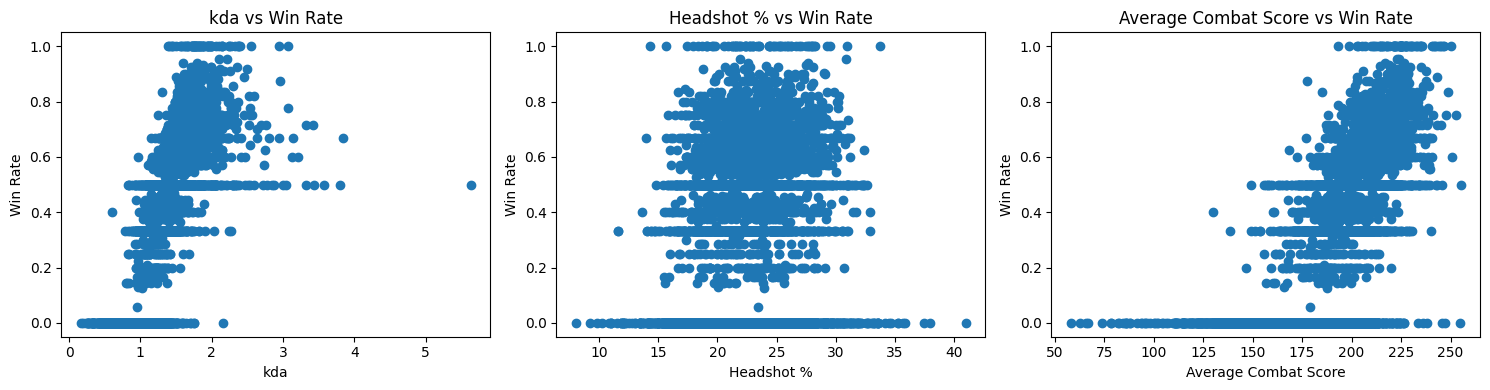

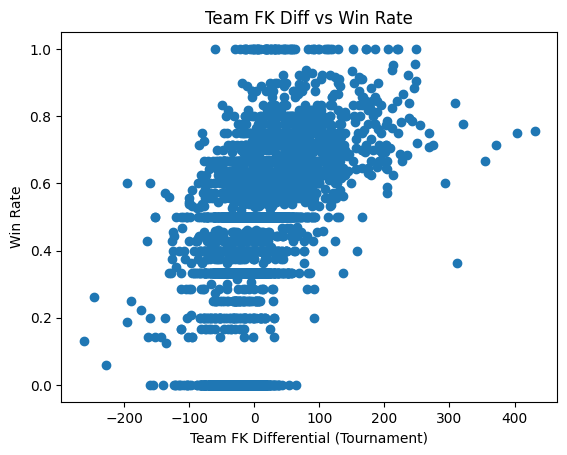

In [83]:
# ==========PLAYER STATS==========

import matplotlib.pyplot as plt
# Make sure 'Headshot %' is numeric (can't run multiple times)
player_stats_all['Headshot %'] = player_stats_all['Headshot %'].str.rstrip('%').astype(float)

# Metrics to study
metrics = ['kda', 'Headshot %', 'Average Combat Score']

# --- Aggregate player metrics to team level ---
team_stats = player_stats_all.groupby(
    ['Tournament', 'Teams'],  # consistent column name
    as_index=False
).agg({
    'kda': 'mean',
    'Headshot %': 'mean',
    'Average Combat Score': 'mean'
})

# --- Compute team win rates ---
team_wins = matches[0].groupby(
    ['Tournament', 'team'],  # column name in matches table
    as_index=False
)['win'].mean()

# Rename for consistent merge
team_wins.rename(columns={'team': 'Teams'}, inplace=True)

# --- Merge metrics with win rate ---
team_eda_metrics = team_stats.merge(
    team_wins,
    on=['Tournament', 'Teams'],
    how='inner'
)

# --- Scatter plots for metrics ---
n = len(metrics)

# Create a figure with 1 row and n columns
fig, axes = plt.subplots(1, n, figsize=(5*n, 4))  # adjust width
for i, m in enumerate(metrics):
    ax = axes[i]
    ax.scatter(team_eda_metrics[m], team_eda_metrics['win'])
    ax.set_xlabel(m)
    ax.set_ylabel('Win Rate')
    ax.set_title(f'{m} vs Win Rate')

plt.tight_layout()  # avoids overlapping labels
plt.show()

# Aggregate First Kills / First Deaths per player
player_fk = player_stats_all.groupby(
    ['Tournament', 'Teams', 'Player'],
    as_index=False
).agg({
    'First Kills': 'sum',
    'First Deaths': 'sum'
})

player_fk['fk_diff'] = player_fk['First Kills'] - player_fk['First Deaths']

# Aggregate to team level
team_fk = player_fk.groupby(
    ['Tournament', 'Teams'],
    as_index=False
)['fk_diff'].sum()

# Reuse team_wins (already renamed 'Teams')
team_eda_fk = team_fk.merge(
    team_wins,
    on=['Tournament', 'Teams'],
    how='inner'
)

# Scatter plot FK diff vs Win Rate
plt.scatter(team_eda_fk['fk_diff'], team_eda_fk['win'])
plt.xlabel('Team FK Differential (Tournament)')
plt.ylabel('Win Rate')
plt.title('Team FK Diff vs Win Rate')
plt.show()


In [31]:
# ==========ECO ROUNDS==========
agg_cols = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'Team']

# Eco
eco_team = eco.groupby(agg_cols).agg(
    avg_loadout=('Loadout Value','mean'),
    round_wins=('round_win','sum'),      # sum of wins
    total_rounds=('round_win','count')
).reset_index()

eco_team['round_win_rate'] = eco_team['round_wins'] / eco_team['total_rounds']
eco_team['match_win_proxy'] = (eco_team['round_win_rate'] > 0.5).astype(int)
# Bin avg_loadout into 4 quartiles
eco_team['loadout_bin'] = pd.qcut(eco_team['avg_loadout'], 4)

# Compute average round win rate per bin
bin_summary = eco_team.groupby('loadout_bin')['round_win_rate'].mean().reset_index()

# Optional: also print number of teams per bin
bin_summary['num_teams'] = eco_team.groupby('loadout_bin')['Team'].count().values

print("Eco Rounds: Loadout Value Bins -> Average Round Win Rate")
print(bin_summary)
eco_team['round_bin'] = pd.qcut(eco_team['round_win_rate'], 4)

win_by_bin = eco_team.groupby('round_bin')['match_win_proxy'].mean()
print(win_by_bin)


Eco Rounds: Loadout Value Bins -> Average Round Win Rate
          loadout_bin  round_win_rate  num_teams
0    (-0.001, 3100.0]        0.215132       4650
1  (3100.0, 3466.667]        0.349325       4493
2  (3466.667, 3750.0]        0.570560       4504
3    (3750.0, 4600.0]        0.623195       4373
round_bin
(-0.001, 0.25]    0.000000
(0.25, 0.333]     0.000000
(0.333, 0.667]    0.481314
(0.667, 1.0]      1.000000
Name: match_win_proxy, dtype: float64


C:\Users\noble\AppData\Local\Temp\ipykernel_5896\740002050.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = eco_team.groupby('loadout_bin')['round_win_rate'].mean().reset_index()
C:\Users\noble\AppData\Local\Temp\ipykernel_5896\740002050.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary['num_teams'] = eco_team.groupby('loadout_bin')['Team'].count().values
C:\Users\noble\AppData\Local\Temp\ipykernel_5896\740002050.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

In [34]:
# ==========PISTOL ROUNDS==========
agg_cols = ['Tournament', 'Stage', 'Match Type', 'Match Name', 'Map', 'Team']

pistol_team_map = pistol.groupby(agg_cols).agg(
    avg_pistol_wins=('Won', 'mean')
).reset_index()

# Cap at 2
pistol_team_map['avg_pistol_wins'] = pistol_team_map['avg_pistol_wins'].clip(upper=2)
pistol_team_map['pistol_win_rate'] = pistol_team_map['avg_pistol_wins'] / 2

# Merge with matches table
pistol_team_map = pistol_team_map.rename(columns={'Team':'team'})

model_df = matches[0].merge(
    pistol_team_map,
    on=['Tournament','Stage','Match Type','Map','team'],
    how='left'
)

model_df[['avg_pistol_wins','pistol_win_rate']] = model_df[['avg_pistol_wins','pistol_win_rate']].fillna(0)

# --- Bin pistol wins (0, 1, 2) ---
model_df['pistol_wins_bin'] = model_df['avg_pistol_wins'].round(0).astype(int)  # round to nearest int

# --- Aggregate map win rate per bin ---
pistol_bin_summary = model_df.groupby('pistol_wins_bin').agg(
    map_win_rate=('win', 'mean'),
    num_maps=('win', 'count')
).reset_index().sort_values('pistol_wins_bin')

print(pistol_bin_summary)

   pistol_wins_bin  map_win_rate  num_maps
0                0      0.416425     16207
1                1      0.503247      9240
2                2      0.756024      5271


In [ ]:
# ==========WIN RATE==========
# 1️⃣ Compute historical win rate per Team × Map
team_map_winrate = matches[1].groupby(['team','Map']).agg(
    historical_win_rate=('win', 'mean'),
    num_matches=('win', 'count')
).reset_index()

# 2️⃣ Merge historical win rate back to each match
matches_with_history = matches[1].merge(
    team_map_winrate,
    on=['team','Map'],
    how='left'
)

# Keep relevant columns for checking
matches_with_history[['team','Map','win','historical_win_rate']].head()

# 3️⃣ Compute correlation between historical win rate and actual match outcomes
corr = matches_with_history['win'].corr(matches_with_history['historical_win_rate'])
print(f"Correlation between historical map win rate and actual wins: {corr:.3f}")


Correlation between historical map win rate and actual wins: 0.598


In [ ]:
# ==========OPPONENT MAP MATCHUP==========
matchup_stats = matches[0].groupby(['team', 'opponent', 'Map']).agg(
    matches_played=('win','count'),
    wins=('win','sum'),
    win_rate=('win','mean')
).reset_index()

matchup_stats.sort_values(['win_rate'], ascending=False).head(10)

matches_with_matchup = matches[0].merge(
    matchup_stats,
    on=['team','opponent','Map'],
    how='left',
    suffixes=('','_hist')
)

matches_with_matchup[['team','opponent','Map','win','win_rate']].head()

corr_matchup = matches_with_matchup['win'].corr(matches_with_matchup['win_rate'])
print(f"Correlation team vs opponent map matchup: {corr_matchup:.3f}")



Correlation team vs opponent map matchup: 0.960


In [69]:
# ==========MAP PICKS AND BANS==========
# 1️⃣ Compute team × map win rate
team_map_winrate = matches[0].groupby(['team', 'Map']).agg(
    matches_played=('win','count'),
    wins=('win','sum'),
    win_rate=('win','mean')
).reset_index()

# 2️⃣ Merge picks/bans with win rate
pickban_analysis = pickban_counts.merge(
    team_map_winrate,
    left_on=['Team','Map'],
    right_on=['team','Map'],
    how='left'
)

# 3️⃣ Compute fractions of total actions per team
# Total number of picks + bans per team
team_total_actions = pickban_analysis.groupby('Team')['count'].sum().reset_index().rename(columns={'count':'total_actions'})

pickban_analysis = pickban_analysis.merge(team_total_actions, on='Team', how='left')

# Fraction of actions per map
pickban_analysis['action_fraction'] = pickban_analysis['count'] / pickban_analysis['total_actions']

# 4️⃣ Pivot picks and bans into separate columns
pick_fraction = pickban_analysis[pickban_analysis['Action']=='pick'][['Team','Map','action_fraction']].rename(columns={'action_fraction':'pick_fraction'})
ban_fraction = pickban_analysis[pickban_analysis['Action']=='ban'][['Team','Map','action_fraction']].rename(columns={'action_fraction':'ban_fraction'})

team_map_pref = pick_fraction.merge(ban_fraction, on=['Team','Map'], how='outer').fillna(0)

# 5️⃣ Compute preference score (pick_fraction - ban_fraction)
team_map_pref['pref_score'] = team_map_pref['pick_fraction'] - team_map_pref['ban_fraction']

# 6️⃣ Merge actual win rate
team_map_pref = team_map_pref.merge(
    team_map_winrate[['team','Map','win_rate']],
    left_on=['Team','Map'],
    right_on=['team','Map'],
    how='left'
)

# Keep relevant columns
team_map_pref = team_map_pref[['Team','Map','pick_fraction','ban_fraction','pref_score','win_rate']]
team_map_pref.head()

,Team,Map,pick_fraction,ban_fraction,pref_score,win_rate
0,100 Thieves,Ascent,0.200000,0.000000,0.200000,0.714286
1,100 Thieves,Bind,0.046154,0.230769,-0.184615,0.466667
2,100 Thieves,Breeze,0.092308,0.015385,0.076923,0.636364
3,100 Thieves,Haven,0.153846,0.015385,0.138462,0.575758
4,100 Thieves,Icebox,0.123077,0.015385,0.107692,0.730769


### 1.3 Correlation Pruning EDA

In [84]:
# ==========KDA VS ACS==========
corr_matrix = team_eda_metrics[['kda', 'Average Combat Score']].corr()
print("Correlation matrix:\n", corr_matrix)

threshold = 0.8  # you can adjust
if abs(corr_matrix.loc['kda','Average Combat Score']) > threshold:
    print(f"KDA and ACS are highly correlated ({corr_matrix.loc['kda','Average Combat Score']:.2f}), pruning ACS")
    team_eda_metrics = team_eda_metrics.drop(columns=['Average Combat Score'])
    metrics = [m for m in metrics if m != 'Average Combat Score']  # update metrics list for plots
else:
    print(f"KDA and ACS correlation is moderate ({corr_matrix.loc['kda','Average Combat Score']:.2f}), keep both")


Correlation matrix:
                            kda  Average Combat Score
kda                   1.000000              0.855116
Average Combat Score  0.855116              1.000000
KDA and ACS are highly correlated (0.86), pruning ACS


### 1.4 Bivariate & Grouped EDA

### Finalized Stats
Removed ACS. Removing headshot %